# June 3, 2024: measure(s) of variations of community labels of rois

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

from brainrender import Scene, actor

import vedo
vedo.settings.default_backend = 'k3d'
from vedo import Volume, Plotter

from brainglobe_utils.IO.image.load import load_nii

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import colorcet as cc

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
RECONST_method = '' #f'lds' #f'normal_dist'
if RECONST_method == '':
    GRAPH_type = f'correlation_graph'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}/density-{args.denst}'
    FC_path = f'{ROI_RESULTS_path}/corr_mats'
else: 
    GRAPH_type = f'reconstructed_graph/{RECONST_method}'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}'
    GRAPHS_path = f'{ROI_RESULTS_path}/graphs'

SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group/soft')
os.system(f'mkdir -p {NII_path}/group/entropy')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group')
HTML_path = f'{ROI_RESULTS_path}/htmls'
os.system(f'mkdir -p {HTML_path}/group/soft/indexes')
os.system(f'mkdir -p {HTML_path}/group/entropy/indexes')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
roi_names = pd.read_csv(f'{PARCELS_path}/{DESC}_desc-names.csv', names=['label', 'name'], delimiter='\t')

In [6]:
models_list = [
    ('', 'a'),
    ('dc', 'd'),
    ('dc', 'h'),
    ('nd', 'd'),
    ('nd', 'h'),
]

In [7]:
def load_modes(args, model):
    args.dc, args.sbm = model
    SBM = f'sbm-{args.dc}-{args.sbm}'
    with open(f'{NPY_path}/{SBM}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
    return args, SBM, dfs, mode_df

In [8]:
def plot(args, SBM, mode_df):
    ncols = 3
    nrows = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 4*nrows), dpi=90, sharex=False, sharey=False)
    fig.tight_layout(h_pad=3, w_pad=2.5)

    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    cmap = cc.cm.CET_L12
    ylabels = ['probability, $\omega_k$', 'uncertainty, $\sigma_k$', 'ratio, $\omega_k$ / $\sigma_k$']
    for idx, col in enumerate(mode_df.columns[2:5]):
        ax = axs[idx]
        cs = cmap(rescale(mode_df[col])) if len(mode_df[col]) > 1 else cmap(rescale(mode_df[col].to_list() + [0.0]))
        sns.barplot(data=mode_df, x=mode_df.index.to_list(), y=mode_df[col].to_list(), ax=ax, palette=cs, width=0.9)
        ax.set(ylabel=ylabels[idx], xlabel='mode $k$')
        if idx == 1: ax.set(title=f'{SBM} mode summary')

    plt.savefig(f'{PNG_path}/group/{SBM}_desc-summary.png', bbox_inches='tight')
    return None

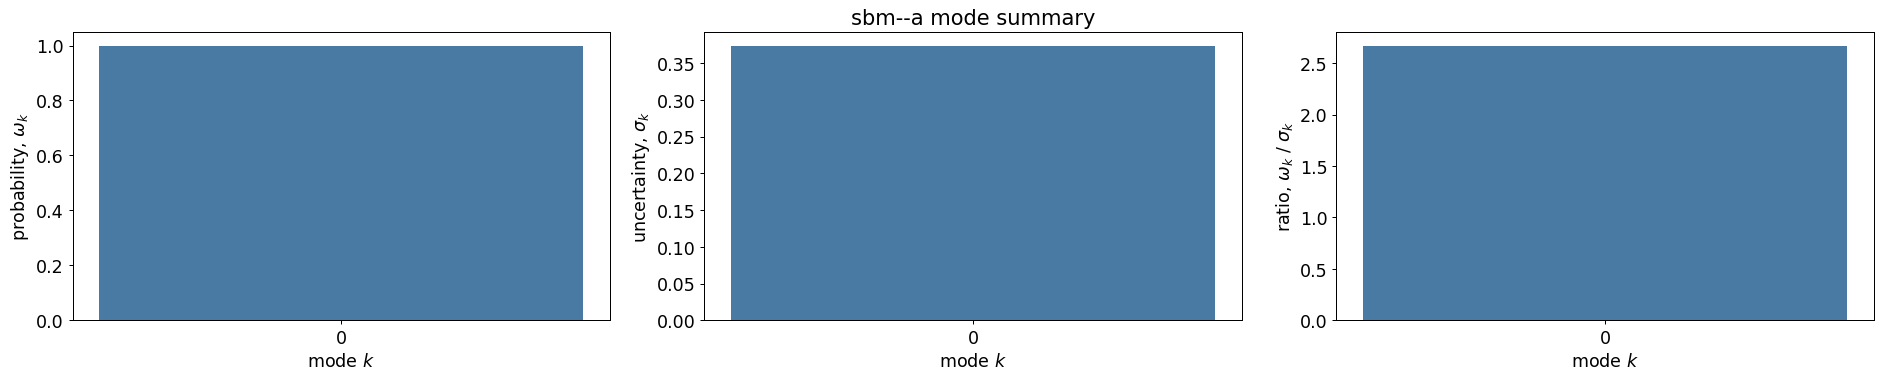

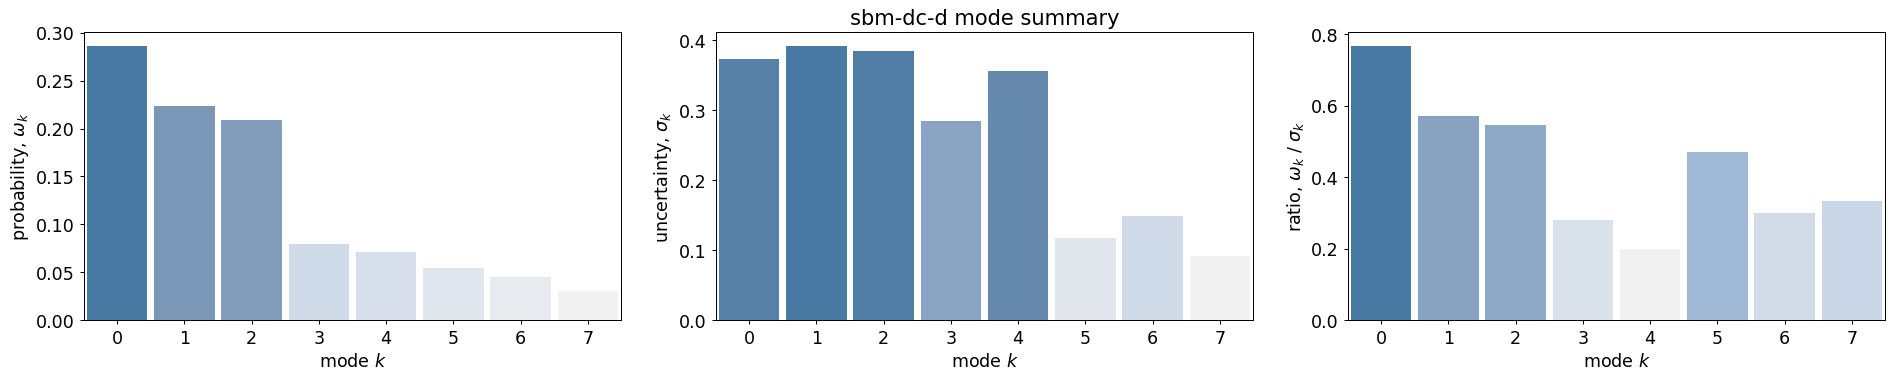

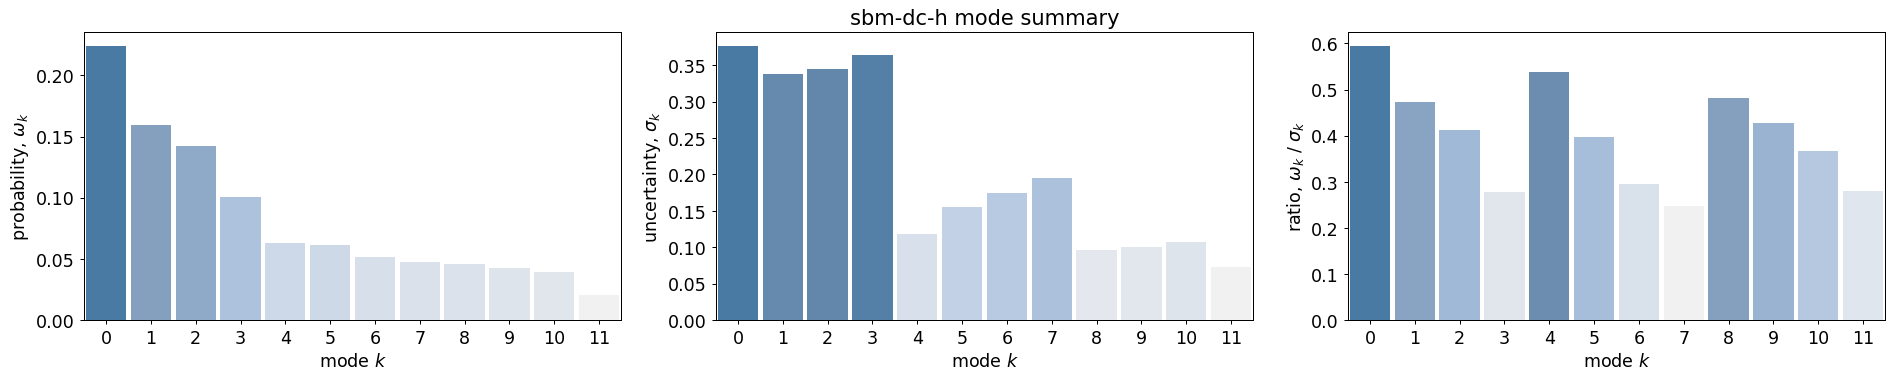

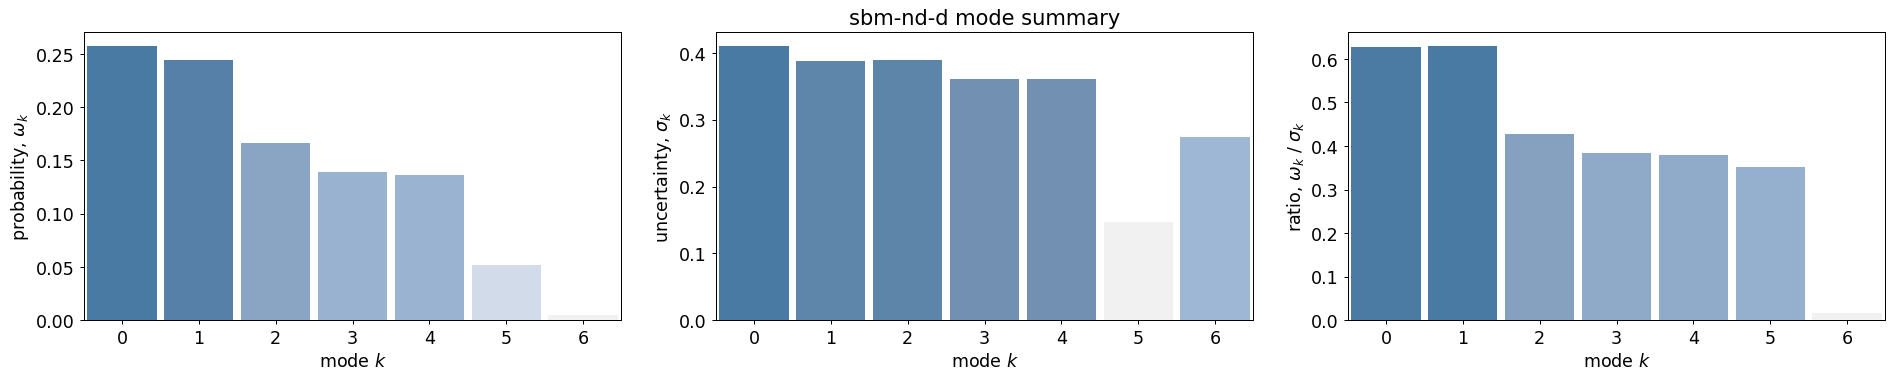

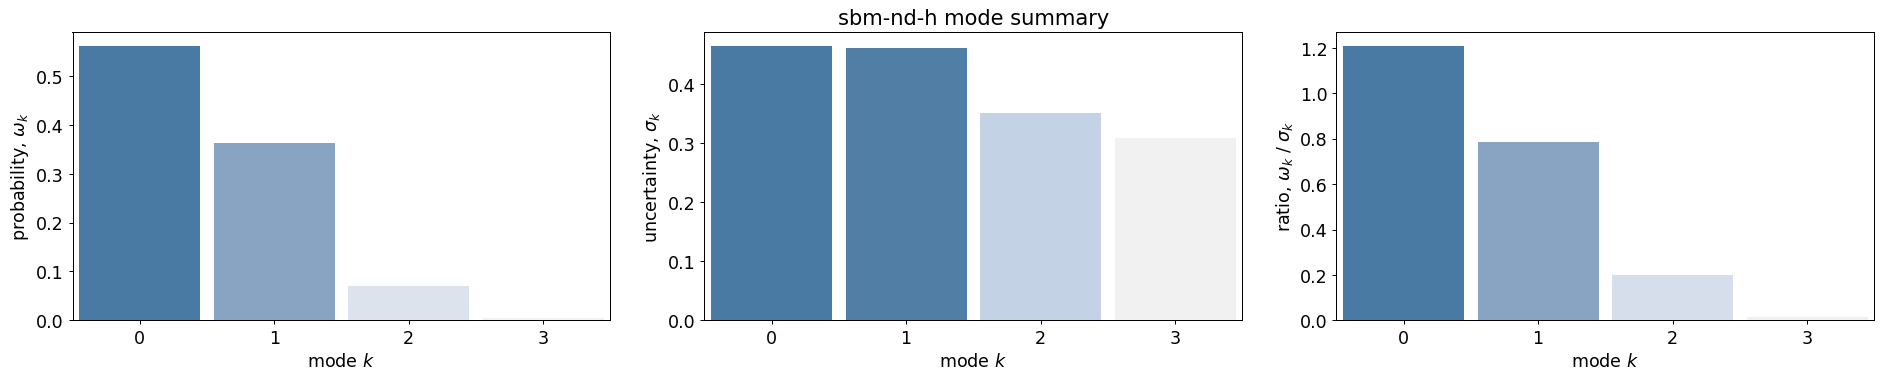

In [9]:
for model in models_list:
    args, SBM, dfs, mode_df = load_modes(args, model)
    plot(args, SBM, mode_df)

---

In [10]:
args, SBM, dfs, mode_df = load_modes(args, model=models_list[4])
SBM

'sbm-nd-h'

In [11]:
mode_df

,mode_id,mode,omega,sigma,ratio,b
0,0,<graph_tool.inference.partition_modes.Partitio...,0.563353,0.465163,1.211087,"[[0, 1, 1, 2, 3, 3, 4, 0, 0, 4, 3, 1, 3, 2, 0,..."
1,1,<graph_tool.inference.partition_modes.Partitio...,0.362573,0.460341,0.787618,"[[0, 4, 1, 2, 6, 3, 4, 6, 3, 12, 3, 1, 0, 6, 3..."
2,2,<graph_tool.inference.partition_modes.Partitio...,0.070175,0.350137,0.200423,"[[3, 1, 18, 2, 6, 6, 4, 0, 1, 12, 3, 1, 3, 0, ..."
3,3,<graph_tool.inference.partition_modes.Partitio...,0.003899,0.308642,0.012632,"[[3, 4, 4, 0, 3, 3, 4, 0, 0, 4, 3, 4, 0, 3, 3,..."


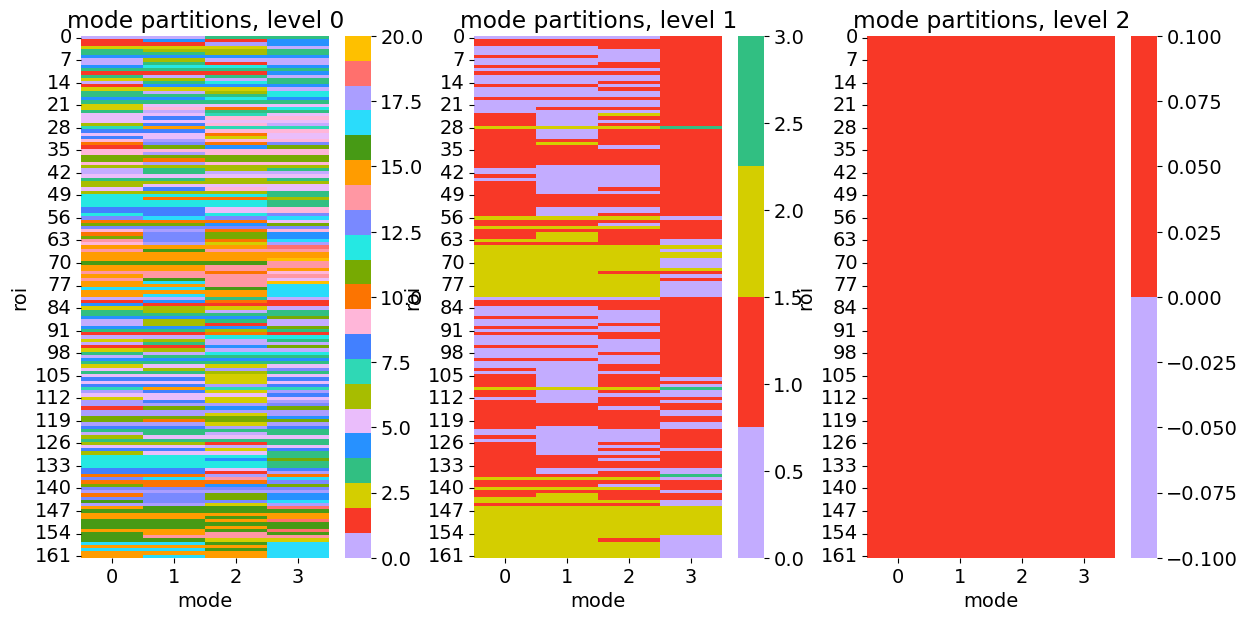

In [12]:
def collect_nested_mode_partitions(args, mode_df):
    Xs = []
    for level in range(3):
        X = np.stack([bs[level] for bs in mode_df['b'].to_list()]).T
        Xs.append(X)
    Xs = np.stack(Xs, axis=-1)
    return Xs

def collect_mode_partitions(args, mode_df):
    # partition matrix
    X = np.stack(mode_df['b'].to_list()).T
    print(X.shape)
    return X

def get_uniform_colors():
    colors_val = []
    for idx in np.arange(5, 56, 10):
        colors_val += cc.CET_C6s[idx:256:55]
    colors_val.pop(6)
    colors_rgb = [colors.to_rgb(c) for c in colors_val]
    return colors_val, colors_rgb

def make_cmap(args, X, colors_val, colors_rgb):
    max_num_colors = np.max(X)+1
    max_num_colors = max_num_colors if max_num_colors > 1 else 2
    colors_val = colors_val[:max_num_colors]
    colors_rgb = colors_rgb[:max_num_colors]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_rgb, N=len(colors_rgb))
    # display(cmap)
    return cmap

def visualize_nested_modes(args, Xs):
    nrows=1
    ncols=3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
    fig.tight_layout(h_pad=3)
    colors_val, colors_rgb = get_uniform_colors()
    for level in range(ncols):
        ax = axs[level]
        X = Xs[:, :, level]
        cmap = make_cmap(args, X, colors_val, colors_rgb)
        sns.heatmap(X, ax=ax, cmap=cmap)
        ax.set(title=f'mode partitions, level {level}', ylabel=f'roi', xlabel=f'mode')
    return fig

def visualize_modes(args, X):
    nrows = 1
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
    fig.tight_layout(h_pad=3)
    colors_val, colors_rgb = get_uniform_colors()
    cmap = make_cmap(args, X, colors_val, colors_rgb)
    ax = axs
    sns.heatmap(X, ax=ax, cmap=cmap)
    ax.set(title=f'mode partitions', ylabel=f'roi', xlabel=f'mode')
    return fig

omegas = np.array(mode_df['omega'].to_list())
if args.sbm in ['h']:
    Xs = collect_nested_mode_partitions(args, mode_df)
    visualize_nested_modes(args, Xs)
elif args.sbm in ['a', 'd']:
    X = collect_mode_partitions(args, mode_df)
    visualize_modes(args, X)

---

In [13]:
def create_soft_comms(args, X, omegas):
    # considering a comm. as a random variable, and soft-comm. as its expectation
    all_comms = np.unique(X)
    comms_mat = np.zeros((X.shape[0], X.shape[1], np.max(all_comms)+1)) # num_rois, num_modes, num_comms
    for comm in all_comms:
        comms_mat[:, :, comm] = (X == comm).astype(int)
    soft_comms = np.average(comms_mat, axis=1, weights=omegas)
    return soft_comms, comms_mat

def plot_soft_comms(args, soft_comms):
    fig, axs = plt.subplots(1, 1, figsize=(4, 6))
    ax = axs
    sns.heatmap(soft_comms, ax=ax, cmap=cc.cm.CET_L12)#'viridis')
    ax.set(xlabel=f'community', ylabel=f'roi', title=f'soft-communities')

In [14]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def soft_comms_to_nifti(args, X, level=-1):
    args.num_rois, args.num_comms = X.shape

    in_files = []
    for idx_comm in range(args.num_comms):
        x = X[:, idx_comm]
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx])
        
        file = f'{NII_path}/group/soft/sbm-{args.dc}-{args.sbm}_desc-soft-comm-{idx_comm}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)

    if level == -1:
        out_file = f'{NII_path}/group/soft/sbm-{args.dc}-{args.sbm}_desc-soft-comms.nii.gz'
    else:
        out_file = f'{NII_path}/group/soft/sbm-{args.dc}-{args.sbm}_level-{level}_desc-soft-comms.nii.gz'
    concatenate(in_files, out_file)
    return None

def create_nested_soft_comms(args, Xs, omegas):
    soft_comms = []
    comms_mats = []
    for level in range(Xs.shape[-1]):
        X = Xs[:, :, level]
        sfs, cms = create_soft_comms(args, X, omegas)
        soft_comms.append(sfs)
        comms_mats.append(cms)
    return soft_comms, comms_mats

def nested_soft_comms_to_nifti(args, soft_comms):
    for level in range(len(soft_comms)):
        soft_comms_to_nifti(args, soft_comms[level], level=level)

def plot_nested_soft_comms(args, soft_comms):
    nrows = 1
    ncols = len(soft_comms)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
    fig.tight_layout(h_pad=3)
    for level in range(ncols):
        ax = axs[level]
        sns.heatmap(soft_comms[level], ax=ax, cmap=cc.cm.CET_L12)
        ax.set(xlabel=f'community', ylabel=f'roi', title=f'soft-communities, level {level}')

240708-16:30:47,894 nipype.interface INFO:
	 stderr 2024-07-08T16:30:47.894855:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240708-16:30:47,907 nipype.interface INFO:
	 stderr 2024-07-08T16:30:47.907396:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240708-16:30:47,909 nipype.interface INFO:
	 stderr 2024-07-08T16:30:47.909307:*+ WARNING: Set TR of output dataset to 1.0 s
240708-16:30:48,42 nipype.interface INFO:
	 stderr 2024-07-08T16:30:48.042366:++ elapsed time = 0.1 s
240708-16:30:48,765 nipype.interface INFO:
	 stderr 2024-07-08T16:30:48.765454:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
240708-16:30:48,768 nipype.interface INFO:
	 stderr 2024-07-08T16:30:48.768662:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240708-16:30:48,771 nipype.interface INFO:
	 stderr 2024-07-08T16:30:48.771111:*+ WARNING: Set TR of output dataset to 1.0 s
240708-16:30:48,817 nipype.interface INFO:
	 stderr 2024-07-

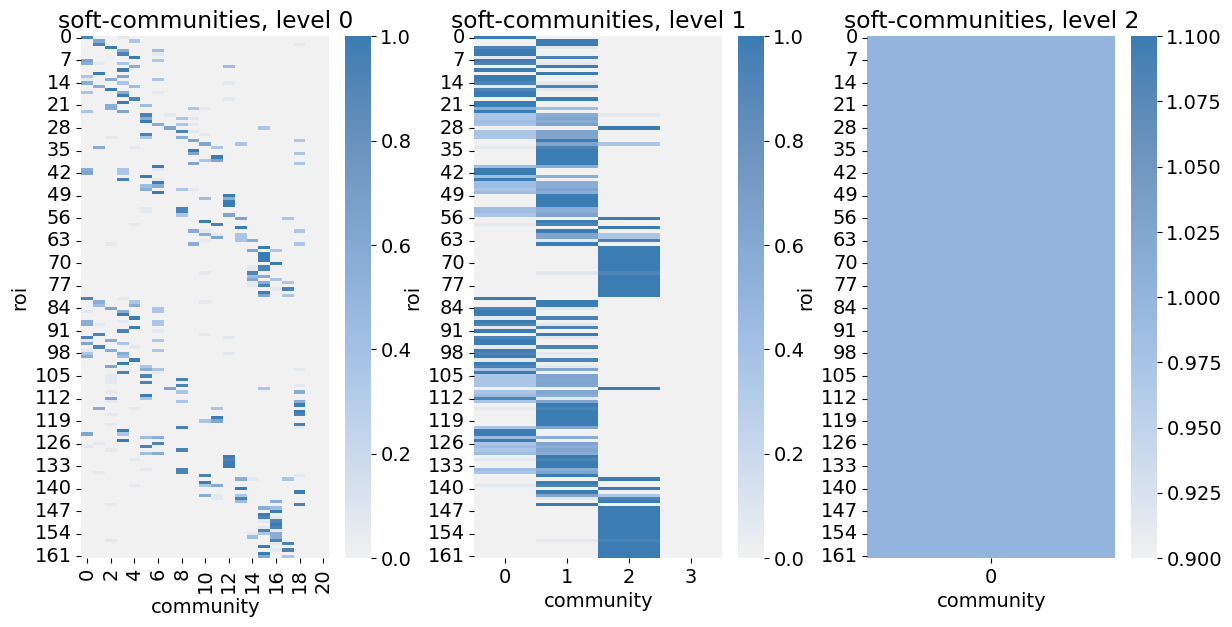

In [15]:
if args.sbm in ['a', 'd']:
    soft_comms, comms_mat = create_soft_comms(args, X, omegas)
    soft_comms_to_nifti(args, X=soft_comms)
    plot_soft_comms(args, soft_comms)
    
if args.sbm in ['h']:
    soft_comms, comms_mats = create_nested_soft_comms(args, Xs, omegas)
    nested_soft_comms_to_nifti(args, soft_comms)
    plot_nested_soft_comms(args, soft_comms)

---

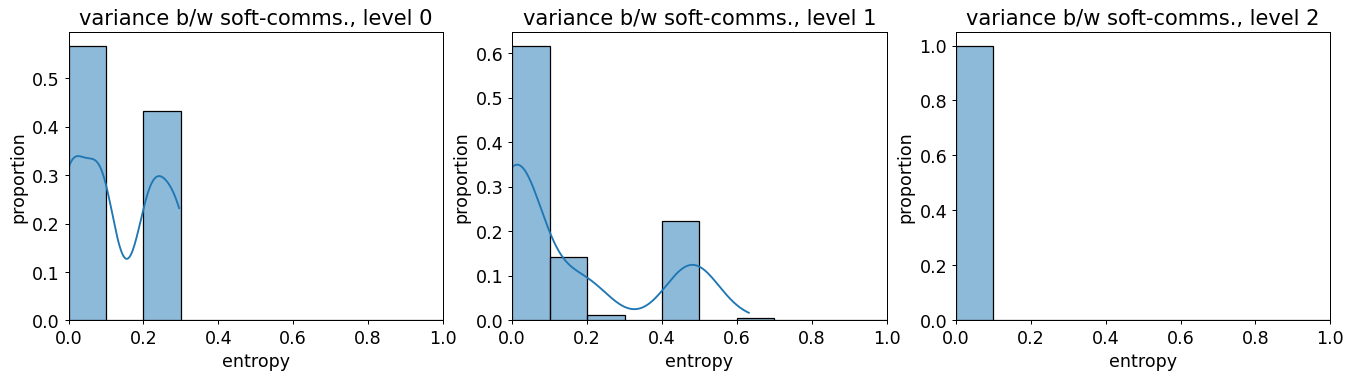

In [16]:
# entropy to measure overlap between soft-comms.
def entropy(X):
    ent = stats.entropy(X, base=2, axis=-1) / np.log2(X.shape[-1])
    ent = np.nan_to_num(ent)
    return ent, stats.rankdata(ent) / X.shape[0]

def plot_entropy(args, ent):
    nrows, ncols = 1, 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90)
    fig.tight_layout(h_pad=3)
    ax = axs
    sns.histplot(ent, ax=ax, stat='proportion', binwidth=0.1, binrange=[0, 1], kde=True)
    ax.set(title=f'variance b/w soft-comms.', xlabel=f'entropy', ylabel=f'proportion', xlim=[0, 1])

def nested_entropy(Xs):
    ents = []
    rank_ents = []
    for level, X in enumerate(Xs):
        ent, rank_ent = entropy(X)
        ents.append(ent)
        rank_ents.append(rank_ent)
    return ents, rank_ents

def plot_nested_entropy(args, ents):
    nrows = 1
    ncols = len(ents)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90)
    fig.tight_layout(h_pad=3)
    for level, ent in enumerate(ents):
        ax = axs[level]
        sns.histplot(ent, ax=ax, stat='proportion', binwidth=0.1, binrange=[0, 1], kde=True)
        ax.set(title=f'variance b/w soft-comms., level {level}', xlabel=f'entropy', ylabel=f'proportion', xlim=[0, 1])
        
def entropy_to_nifti(args, x, level=-1):
    args.num_rois = x.shape[0]

    x_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        x_img += (parcels == roi) * (x[idx])
    
    if level == -1:
        file = f'{NII_path}/group/entropy/sbm-{args.dc}-{args.sbm}_desc-ent.nii.gz'
    else:
        file = f'{NII_path}/group/entropy/sbm-{args.dc}-{args.sbm}_level-{level}_desc-ent.nii.gz'
    parcels_img.new_image_like(x_img).to_filename(file)

    return None

def nested_entropy_to_nifti(args, X):
    for level, x in enumerate(X):
        entropy_to_nifti(args, x, level)

if args.sbm in ['a', 'd']:
    ent, rank_ent = entropy(soft_comms)
    plot_entropy(args, ent)
    entropy_to_nifti(args, ent)
    
if args.sbm in ['h']:
    ents, rank_ents = nested_entropy(soft_comms)
    plot_nested_entropy(args, ents)
    nested_entropy_to_nifti(args, ents)

---

In [17]:
def get_colors(args, X):
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    cmap = cc.cm.CET_L12 #mpl.colormaps['Blues'] #mpl.colormaps['viridis']
    vals_list = np.unique(X)
    colors_list = cmap(rescale(vals_list))
    colors_list = [colors.to_hex(c) for c in colors_list]
    colors_df = pd.DataFrame({
        'val':vals_list,
        'color':colors_list,
    })
    return colors_df

In [18]:
def add_vol(args, scene, vol, color='#cccccc', alpha=0.2, label='template'):
    mesh = vol.isosurface()
    mesh = mesh.smooth(
        niter=1000, 
        pass_band=0.1, 
        edge_angle=15, 
        feature_angle=150,
        boundary=False,
    )
    mesh_actor = actor.Actor(
        mesh, 
        name=f'{label}', 
        br_class='Volume', 
        color=color, 
        alpha=alpha,
    )
    scene.add(mesh_actor)
    # scene.add_label(actor=mesh_actor, label=label)
    return scene

In [19]:
def visualize_soft_comms(args, template, data, colors_df, file):
    def visualize_soft_comm(args, template, data_vol, colors_df, file, idx_comm):
        # scene
        scene = Scene()
        root_brain = scene.get_actors()[0].alpha(0.0)
        
        spacing=[args.spacing]*3
        
        # brain template
        vol = Volume(template, origin=[-75,0,0], spacing=spacing)
        scene = add_vol(
            args, scene, vol=vol, 
            color='#cccccc', alpha=0.2,
            label='template'
        )
        
        # brain data for a community
        fs = file.split('/')
        filename = '_'.join(fs[-1].split('_')[:-1] + [f'desc-soft-comm-{idx_comm:02d}.html'])
        filename = f'{HTML_path}/group/soft/{filename}'
        
        # for val in np.unique(data_vol)[1:]:
        for roi in roi_labels:
            val = np.unique((parcels == roi) * data_vol)
            val = val[1] if len(val) > 1 else val
            alpha = 0.05 if val == 0.0 else 1.0
            clr = colors_df.iloc[(colors_df['val']-val).abs().argsort()[0]]['color']
            clr = '#cccccc' if val == 0.0 else clr
            roi_vol = (parcels == roi)
            roi_vol = Volume(roi_vol, origin=[0,0,0], spacing=spacing)
            scene = add_vol(
                args, scene, vol=roi_vol, 
                color=clr,
                alpha=alpha,
                label=f'roi {roi}',
            )
        scene.export(f'{filename}')
        return None

    if len(data.shape) > 3:
        for idx_comm in range(data.shape[-1]):
            visualize_soft_comm(args, template, data[:, :, :, idx_comm], colors_df, file, idx_comm)
    else:
        visualize_soft_comm(args, template, data, colors_df, file, 0)
    return None

In [20]:
args.spacing = 400 #um # 200
template = f'{BASE_path}/gabe_symmetric_N162/Symmetric_N162_0.20_RAS.nii.gz'
template = load_nii(template, as_array=True)

files = sorted(glob.glob(f'{NII_path}/group/soft/{SBM}*',))
if args.sbm in ['a', 'd']:
    file = files[0]
    colors_df = get_colors(args, soft_comms)
    data = load_nii(file, as_array=True)
    visualize_soft_comms(args, template, data, colors_df, file)

if args.sbm in ['h']:
    for sft_cms, file in zip(soft_comms, files):
        print(file.split('/')[-1])
        colors_df = get_colors(args, sft_cms)
        data = load_nii(file, as_array=True)
        visualize_soft_comms(args, template, data, colors_df, file)

sbm-nd-h_level-0_desc-soft-comms.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-00.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-01.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-02.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-03.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-04.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-05.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-06.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-07.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-08.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-09.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-10.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-11.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-12.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-13.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-14.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-15.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-16.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-17.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-18.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-19.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-0_desc-soft-comm-20.html

sbm-nd-h_level-1_desc-soft-comms.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-1_desc-soft-comm-00.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-1_desc-soft-comm-01.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-1_desc-soft-comm-02.html

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-1_desc-soft-comm-03.html

sbm-nd-h_level-2_desc-soft-comms.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/soft/sbm-nd-h_level-2_desc-soft-comm-00.html

In [21]:
def combine_soft_htmls(args, SBM, html_files, level=-1, folder_name='soft'):
  # Create the main HTML content
  html_content = """
  <!DOCTYPE html>
  <html lang="en">
  <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>HTML Grid with Headings</title>
    <style>
      body {
        display: grid;
        grid-template-columns: repeat(auto-fill, minmax(1000px, 1fr));
        gap: 20px;
        padding: 20px;
      }
      iframe {
        width: 850px;
        height: 850px;
        border: none;
      }
      .grid-item {
        text-align: center;
        margin-bottom: 10px;
      }
      h2 {
        margin: 0;
      }
    </style>
  </head>
  <body>
  """
  # Add iframes and headings for each HTML file
  for html_file in html_files:
    # Extract filename (without extension) for heading
    filename, _ = os.path.splitext(html_file.split('/')[-1])
    heading = f'<h2>{filename}</h2>'  # Capitalize the filename for title
    iframe_tag = f'<div class="grid-item">{heading}<iframe src="{html_file}"></iframe></div>'
    html_content += iframe_tag
  # Close the HTML content
  html_content += """
  </body>
  </html>
  """
  # Write the content to an index.html file
  if level == -1:
    with open(os.path.join(f'{HTML_path}/group/{folder_name}/indexes', f"{SBM}_desc-index.html"), "w") as f:
        f.write(html_content)
  else:
    with open(os.path.join(f'{HTML_path}/group/{folder_name}/indexes', f"{SBM}_level-{level}_desc-index.html"), "w") as f:
        f.write(html_content)
  print("index.html has been created successfully.")

In [22]:
if args.sbm in ['a', 'd']:
    html_files = sorted(glob.glob(f'{HTML_path}/group/soft/{SBM}*'))
    combine_soft_htmls(args, SBM, html_files)
    
if args.sbm in ['h']:
    for level in range(3):
        html_files = sorted(glob.glob(f'{HTML_path}/group/soft/{SBM}_level-{level}*'))
        combine_soft_htmls(args, SBM, html_files, level)

index.html has been created successfully.
index.html has been created successfully.
index.html has been created successfully.


---

In [23]:
# visualize entropy files
def visualize_entropy(args, template, data_vol, colors_df, file):
    # scene
    scene = Scene()
    root_brain = scene.get_actors()[0].alpha(0.0)
    
    spacing=[args.spacing]*3
    
    # brain template
    vol = Volume(template, origin=[-75,0,0], spacing=spacing)
    scene = add_vol(
        args, scene, vol=vol, 
        color='#cccccc', alpha=0.2,
        label='template'
    )
    
    # brain data
    fs = file.split('/')
    filename = '_'.join(fs[-1].split('_')[:-1] + [f'desc-entropy.html'])
    filename = f'{HTML_path}/group/entropy/{filename}'
    
    for roi in roi_labels:
        val = np.unique((parcels == roi) * data_vol)
        val = val[1] if len(val) > 1 else val
        alpha = 0.05 if val == 0.0 else 1.0
        clr = colors_df.iloc[(colors_df['val']-val).abs().argsort()[0]]['color']
        clr = '#cccccc' if val == 0.0 else clr
        roi_vol = (parcels == roi)
        roi_vol = Volume(roi_vol, origin=[0,0,0], spacing=spacing)
        scene = add_vol(
            args, scene, vol=roi_vol, 
            color=clr,
            alpha=alpha,
            label=f'roi {roi}',
        )
    scene.export(f'{filename}')
    return None

In [24]:
colors_df = get_colors(args, np.arange(0, 1, 0.01))

args.spacing = 400 #um # 200
template = f'{BASE_path}/gabe_symmetric_N162/Symmetric_N162_0.20_RAS.nii.gz'
template = load_nii(template, as_array=True)

files = sorted(glob.glob(f'{NII_path}/group/entropy/{SBM}*',))
if args.sbm in ['a', 'd']:
    file = files[0]
    data = load_nii(file, as_array=True)
    visualize_entropy(args, template, data, colors_df, file)

if args.sbm in ['h']:
    for ent, file in zip(ents, files):
        print(file.split('/')[-1])
        data = load_nii(file, as_array=True)
        visualize_entropy(args, template, data, colors_df, file)

sbm-nd-h_level-0_desc-ent.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/entropy/sbm-nd-h_level-0_desc-entropy.html

sbm-nd-h_level-1_desc-ent.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/entropy/sbm-nd-h_level-1_desc-entropy.html

sbm-nd-h_level-2_desc-ent.nii.gz


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/mouse_dataset/roi_results/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/seswise/correlation
_graph/density-25/htmls/group/entropy/sbm-nd-h_level-2_desc-entropy.html

In [25]:
def combine_entropies(args, SBM, html_files):
    # Create the main HTML content
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>HTML Grid with Headings</title>
        <style>
            body {
                display: grid;
                grid-template-columns: repeat(auto-fill, minmax(1000px, 1fr));
                gap: 20px;
                padding: 20px;
            }
            iframe {
                width: 850px;
                height: 850px;
                border: none;
            }
            .grid-item {
                text-align: center;
                margin-bottom: 10px;
            }
            h2 {
                margin: 0;
            }
        </style>
    </head>
    <body>
    """
    # Add iframes and headings for each HTML file
    for html_file in html_files:
        # Extract filename (without extension) for heading
        filename, _ = os.path.splitext(html_file.split('/')[-1])
        heading = f'<h2>{filename}</h2>'  # Capitalize the filename for title
        iframe_tag = f'<div class="grid-item">{heading}<iframe src="{html_file}"></iframe></div>'
        html_content += iframe_tag
    # Close the HTML content
    html_content += """
    </body>
    </html>
    """
    # Write the content to an index.html file
    index_file = os.path.join(f'{HTML_path}/group/entropy/indexes', f"{SBM}_desc-index.html")
    with open(index_file, "w") as f:
        f.write(html_content)
    print("index.html has been created successfully.")

In [26]:
html_files = sorted(glob.glob(f'{HTML_path}/group/entropy/{SBM}*'))
combine_entropies(args, SBM, html_files)

index.html has been created successfully.
